### Homework03 - Reinforcement Learning_part 1

student name : Daniele Mellino <br>
student id : 2013373<br>
Course: Neural Network and Deep Learning <br>
Professor: Testolin Alberto<br>

# Libraries

In [ ]:
!pip install gym
!pip install optuna

     |████████████████████████████████| 308 kB 4.7 MB/s 
     |████████████████████████████████| 210 kB 27.1 MB/s 
     |████████████████████████████████| 80 kB 5.8 MB/s 
     |████████████████████████████████| 75 kB 2.4 MB/s 
     |████████████████████████████████| 113 kB 11.6 MB/s 
     |████████████████████████████████| 149 kB 16.8 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=15ed03645dd51fcdf64b5a3e3527c3c88e0fa211c38722513a56220b63553c51
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import optuna

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state,action,next_state,reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(4, 4, 4, 4), (5, 5, 5, 5)]


# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh). 

Be sure to keep a linear output activation.

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [0.09202248 0.14815502]


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [0.09202248 0.14815502]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

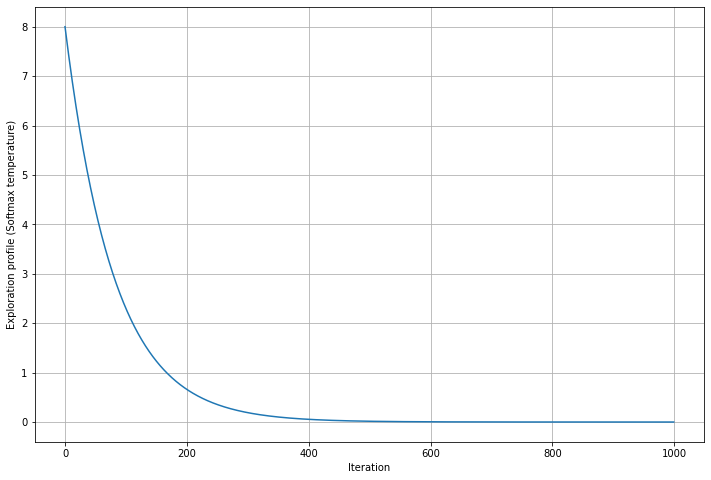

In [ ]:
### Define exploration profile
initial_value = 8
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

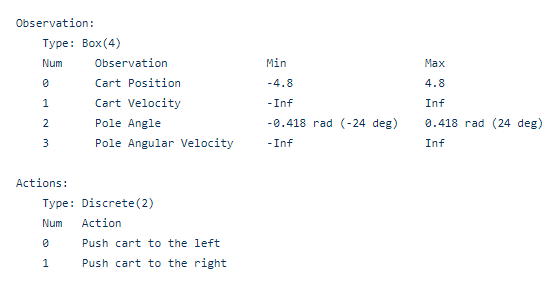

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop (first version)
Reward is not updated

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done and score < 501:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 3.2692032590398465
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 17 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 37 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 14 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 2.9682721884690775
EPISODE: 56 - FINAL SCORE: 43 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 17 - Temperature: 2.8835153180817
EPISODE: 59 - FINAL SCOR

In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.71.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000100.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000200.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000300.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000400.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000500.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000600.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000700.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000800.mp4



SHOWING VIDEO video/openaigym.video.2.71.video000900.mp4


## Training loop (advanced)
Let's modify the reward to improve the results. (add penalty if it go far from the centre)
Add early stopping !

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
done_counter=0
#convergence stop
x=100

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done :

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
          

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state
      #end training after x step in which the loop get the maximum
    if score==500:
        done_counter+=1
    else: done_counter=0

    if done_counter== x:
        print(f"FINAL EPISODE : {episode_num+1}")
        env.close()
        break

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 16 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 46 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 15 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 43 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 20 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 25 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 29 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 13 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 33 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 21 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 28 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 11 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 12 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.6.68.video000000.mp4



SHOWING VIDEO video/openaigym.video.6.68.video000100.mp4



SHOWING VIDEO video/openaigym.video.6.68.video000200.mp4



SHOWING VIDEO video/openaigym.video.6.68.video000300.mp4



SHOWING VIDEO video/openaigym.video.6.68.video000400.mp4


# Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done :
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.5.68.video000000.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000001.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000002.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000003.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000004.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000005.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000006.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000007.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000008.mp4



SHOWING VIDEO video/openaigym.video.5.68.video000009.mp4


# Profiles and Track classes

In [ ]:
# so here I create a class Profile which will be usefull to explore different activation

def positive(x,eps = 5e-6):
    if x<eps: return eps
    else: return x

class Profile():
    def __init__(self, type, temperature_max, num_iter):
        '''
        type can be : 
        0 - boltzmann profile
        1 - linear decaying profile 
        '''
        self.ti = temperature_max
        self.num_iter = num_iter
        self.noise_loc = []

        if type ==0 :
            exp_decay = np.exp(-np.log(temperature_max) / num_iter * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
            self.profile = [temperature_max * (exp_decay ** i) for i in range(num_iter)]
        if type == 1 :
            step = int(num_iter / 2)
            m = temperature_max/step
            self.profile = [positive(temperature_max- i*m) for i in range(num_iter) ]
        return 
    
    def add_gnoise(self, mean = None,std = None):
        if mean == None: mean = np.random.randint(1,self.num_iter)
        if std == None: std = self.num_iter/ 60
        A = self.ti * 5
        self.noise_loc.append((mean,std))
        noise = np.array([A*np.exp(-0.5 * (i-mean)**2/std**2)/(std * np.sqrt(2*np.pi)) for i in range(self.num_iter) ])
        self.profile+=noise
        return

    def plot(self):
        plt.plot(self.profile)
        plt.xlabel("Episode number")
        plt.ylabel("Temperature")
        plt.show()
        return
    def _noise_loc(self):
        return self.noise_loc
    def _profile(self):
        return np.array(self.profile)



# now I define also a class that will help me keep track of the results

class Track():
    def __init__(self):
        self.prof_list = []
        self.scores = []
        return
    def add(self, x , y):
        '''
        x : profile 
        y: scores list for that profile
        '''
        self.prof_list.append(x)
        self.scores.append(y)

    def plot(self, n:int, param): 
        ti = self.prof_list[n][0]
        score = self.scores[n]
        scale = 500 // ti
        plt.plot(scale*self.prof_list(n), label = "scaled Profile, T_max: "+str(ti))
        plt.plot(np.array(score), label = 'Score')
        plt.xlabel("Episodes")
        plt.ylabel("")
        plt.legend()
        plt.show()
        return


# Optuna search

In [ ]:
MAX_ITER = 1000
n_noise=0
train_dict = {
    'state_space_dim': 4,
    'action_space_dim': 2,
    'replay_memory_capacity': 1000,
    'lr' : 1e-2,
    'batch_size': 128,
}


def objective(trial):
    type_penalty = trial.suggest_float("type_penalty", 1, 2.5,step=0.5)
    type_profile = trial.suggest_int("type_profile", 0, 1)
    temp_max = trial.suggest_int("max_temp", 3, 18)
    gamma        = trial.suggest_float("gamma", 0.93, 0.99)
    target_net_update_steps = trial.suggest_int("target_net_update_steps", 1,15,step=1)
    lrt= trial.suggest_float("lr", 0.001, 0.069,step=0.002)


    x=75  #number of step to consider a model arrived to convergence

    ### Initialize the replay memory
    replay_mem = ReplayMemory(10000)    

    ### Initialize the policy network
    policy_net = DQN(4, 2)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(4, 2)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lrt) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    
    done_counter=0

    pr = Profile(type_profile, temp_max, MAX_ITER)
    for i in range(n_noise):
        pr.add_gnoise()
    profile = pr._profile()
        
    score_list = []
    loss_fn = nn.SmoothL1Loss()
    
    for episode_num, tau in enumerate(tqdm(profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done  = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.power(np.abs(state[0]),type_penalty) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, train_dict.get('batch_size'))

            # Set the current state for the next iteration
            state = next_state
            
        if score==500:
            done_counter+=1
        else: done_counter=0

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        

        score_list.append(score)
        

        if done_counter== x:
            track.add(profile,score_list)
            env.close()
            return np.max(np.array(score_list)), len(score_list)-x  #return the maximum
            break

    track.add(profile,score_list)

    if done_counter !=0 :
        env.close()
        return np.max(np.array(score_list)), MAX_ITER-done_counter

    env.close()
    return np.mean(np.array(score_list)[MAX_ITER-x:]), MAX_ITER

In [ ]:
track = Track()
study = optuna.create_study(directions=["maximize", "minimize"])#,sampler=optuna.samplers.RandomSampler())


[I 2022-02-11 13:22:37,822] A new study created in memory with name: no-name-7ffa999f-605c-42ac-9ed9-a49820a1597d


In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

study.optimize(objective, n_trials = 60)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  
[I 2022-02-11 13:26:29,786] Trial 0 finished with values: [95.12, 1000.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 8, 'gamma': 0.9308677365438037, 'target_net_update_steps': 15, 'lr': 0.041}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:33:27,812] Trial 1 finished with values: [223.01333333333332, 1000.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 18, 'gamma': 0.957521698417051, 'target_net_update_steps': 7, 'lr': 0.023}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:36:38,469] Trial 2 finished with values: [73.02666666666667, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 1, 'max_temp': 9, 'gamma': 0.9701371236690158, 'target_net_update_steps': 1, 'lr': 0.001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:41:13,680] Trial 3 finished with values: [137.25333333333333, 1000.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 18, 'gamma': 0.9389230247256967, 'target_net_update_steps': 13, 'lr': 0.033}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:46:19,895] Trial 4 finished with values: [143.16, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 4, 'gamma': 0.9683858055374862, 'target_net_update_steps': 14, 'lr': 0.017}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:54:54,713] Trial 5 finished with values: [500.0, 659.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 6, 'gamma': 0.937527213179264, 'target_net_update_steps': 1, 'lr': 0.023}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 13:57:38,029] Trial 6 finished with values: [73.28, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 1, 'max_temp': 7, 'gamma': 0.9393463502002034, 'target_net_update_steps': 2, 'lr': 0.003}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:07:16,484] Trial 7 finished with values: [230.68, 1000.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 9, 'gamma': 0.936488116902208, 'target_net_update_steps': 3, 'lr': 0.043000000000000003}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:12:48,858] Trial 8 finished with values: [500.0, 705.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 7, 'gamma': 0.9850771919833375, 'target_net_update_steps': 12, 'lr': 0.069}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:27:09,259] Trial 9 finished with values: [500.0, 946.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 9, 'gamma': 0.9715409974878102, 'target_net_update_steps': 8, 'lr': 0.049}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:40:00,509] Trial 10 finished with values: [500.0, 838.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 3, 'gamma': 0.9899474354132929, 'target_net_update_steps': 1, 'lr': 0.041}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:46:39,021] Trial 11 finished with values: [500.0, 648.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 3, 'gamma': 0.9425975467220091, 'target_net_update_steps': 8, 'lr': 0.063}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:50:53,766] Trial 12 finished with values: [126.21333333333334, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 1, 'max_temp': 17, 'gamma': 0.9737457026665414, 'target_net_update_steps': 12, 'lr': 0.035}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 14:57:04,775] Trial 13 finished with values: [500.0, 999.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 7, 'gamma': 0.9658364041600038, 'target_net_update_steps': 15, 'lr': 0.067}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:03:30,746] Trial 14 finished with values: [500.0, 791.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 5, 'gamma': 0.9795291127378188, 'target_net_update_steps': 8, 'lr': 0.033}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:12:09,623] Trial 15 finished with values: [500.0, 974.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 11, 'gamma': 0.9644966284976182, 'target_net_update_steps': 2, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:18:59,128] Trial 16 finished with values: [500.0, 888.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 5, 'gamma': 0.9859830041012546, 'target_net_update_steps': 11, 'lr': 0.009000000000000001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:26:41,653] Trial 17 finished with values: [500.0, 774.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 10, 'gamma': 0.9753294850701201, 'target_net_update_steps': 2, 'lr': 0.057}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:33:07,622] Trial 18 finished with values: [500.0, 488.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 14, 'gamma': 0.9694971015088167, 'target_net_update_steps': 6, 'lr': 0.055}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:38:42,003] Trial 19 finished with values: [116.36, 1000.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 8, 'gamma': 0.9359038198199134, 'target_net_update_steps': 12, 'lr': 0.019000000000000003}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:42:47,009] Trial 20 finished with values: [79.65333333333334, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 17, 'gamma': 0.97762684134341, 'target_net_update_steps': 10, 'lr': 0.041}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:47:49,692] Trial 21 finished with values: [118.73333333333333, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 12, 'gamma': 0.936323267264282, 'target_net_update_steps': 9, 'lr': 0.045}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 15:54:50,385] Trial 22 finished with values: [281.6533333333333, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 18, 'gamma': 0.9569229835894527, 'target_net_update_steps': 8, 'lr': 0.031}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:02:11,480] Trial 23 finished with values: [500.0, 962.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 12, 'gamma': 0.9666379956829659, 'target_net_update_steps': 10, 'lr': 0.019000000000000003}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:05:37,304] Trial 24 finished with values: [118.98666666666666, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 1, 'max_temp': 7, 'gamma': 0.9372367440165218, 'target_net_update_steps': 12, 'lr': 0.057}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:09:54,730] Trial 25 finished with values: [139.16, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 7, 'gamma': 0.9355651369317919, 'target_net_update_steps': 8, 'lr': 0.045}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:15:42,175] Trial 26 finished with values: [150.32, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 6, 'gamma': 0.955886115544118, 'target_net_update_steps': 9, 'lr': 0.017}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:20:32,026] Trial 27 finished with values: [188.98666666666668, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 5, 'gamma': 0.9633924360782522, 'target_net_update_steps': 11, 'lr': 0.039}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:24:01,524] Trial 28 finished with values: [500.0, 513.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 3, 'gamma': 0.9596617358292, 'target_net_update_steps': 3, 'lr': 0.017}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:30:40,719] Trial 29 finished with values: [500.0, 994.0] and parameters: {'type_penalty': 1.5, 'type_profile': 1, 'max_temp': 3, 'gamma': 0.9482355548386538, 'target_net_update_steps': 8, 'lr': 0.053000000000000005}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:34:28,228] Trial 30 finished with values: [79.4, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 5, 'gamma': 0.9829698134884859, 'target_net_update_steps': 10, 'lr': 0.021}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:39:56,945] Trial 31 finished with values: [103.0, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 15, 'gamma': 0.9408734968256102, 'target_net_update_steps': 14, 'lr': 0.023}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:45:17,978] Trial 32 finished with values: [500.0, 998.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 15, 'gamma': 0.9873346237138014, 'target_net_update_steps': 13, 'lr': 0.013000000000000001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:49:54,034] Trial 33 finished with values: [175.08, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 16, 'gamma': 0.9509598250712517, 'target_net_update_steps': 15, 'lr': 0.001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 16:56:40,723] Trial 34 finished with values: [500.0, 522.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 5, 'gamma': 0.944081903279228, 'target_net_update_steps': 2, 'lr': 0.035}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:00:42,318] Trial 35 finished with values: [65.36, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 11, 'gamma': 0.941610989495202, 'target_net_update_steps': 6, 'lr': 0.005}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:06:33,396] Trial 36 finished with values: [500.0, 531.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 10, 'gamma': 0.9556774446221898, 'target_net_update_steps': 5, 'lr': 0.065}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:12:10,190] Trial 37 finished with values: [500.0, 698.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 3, 'gamma': 0.9593811895121154, 'target_net_update_steps': 4, 'lr': 0.009000000000000001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:14:56,170] Trial 38 finished with values: [70.08, 1000.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 17, 'gamma': 0.9602252855982124, 'target_net_update_steps': 12, 'lr': 0.001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:18:34,181] Trial 39 finished with values: [79.98666666666666, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 16, 'gamma': 0.9387531093052501, 'target_net_update_steps': 3, 'lr': 0.001}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:24:02,988] Trial 40 finished with values: [500.0, 749.0] and parameters: {'type_penalty': 1.0, 'type_profile': 1, 'max_temp': 13, 'gamma': 0.9767752170447789, 'target_net_update_steps': 7, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:27:01,063] Trial 41 finished with values: [500.0, 424.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 9, 'gamma': 0.9675058220870574, 'target_net_update_steps': 1, 'lr': 0.005}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:30:57,253] Trial 42 finished with values: [500.0, 518.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 16, 'gamma': 0.9857810480653433, 'target_net_update_steps': 5, 'lr': 0.039}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:36:52,106] Trial 43 finished with values: [500.0, 913.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 11, 'gamma': 0.9886124750190413, 'target_net_update_steps': 11, 'lr': 0.027000000000000003}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:53:03,446] Trial 44 finished with values: [500.0, 936.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 7, 'gamma': 0.9573571411994058, 'target_net_update_steps': 3, 'lr': 0.065}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 17:57:54,052] Trial 45 finished with values: [100.85333333333334, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 18, 'gamma': 0.9496225931340159, 'target_net_update_steps': 13, 'lr': 0.007}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:01:33,615] Trial 46 finished with values: [500.0, 324.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 14, 'gamma': 0.9549577637004715, 'target_net_update_steps': 2, 'lr': 0.045}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:10:19,698] Trial 47 finished with values: [500.0, 968.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 18, 'gamma': 0.9700479220587102, 'target_net_update_steps': 15, 'lr': 0.053000000000000005}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:15:26,839] Trial 48 finished with values: [136.08, 1000.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 6, 'gamma': 0.9345999182663747, 'target_net_update_steps': 13, 'lr': 0.069}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:20:59,483] Trial 49 finished with values: [500.0, 646.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 11, 'gamma': 0.981194464707946, 'target_net_update_steps': 13, 'lr': 0.045}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:24:56,690] Trial 50 finished with values: [500.0, 404.0] and parameters: {'type_penalty': 1.0, 'type_profile': 0, 'max_temp': 14, 'gamma': 0.9767752170447789, 'target_net_update_steps': 7, 'lr': 0.045}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:36:48,126] Trial 51 finished with values: [500.0, 991.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 15, 'gamma': 0.9408734968256102, 'target_net_update_steps': 2, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:44:00,967] Trial 52 finished with values: [500.0, 927.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 9, 'gamma': 0.9700479220587102, 'target_net_update_steps': 15, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:48:45,286] Trial 53 finished with values: [500.0, 644.0] and parameters: {'type_penalty': 2.0, 'type_profile': 0, 'max_temp': 18, 'gamma': 0.9556774446221898, 'target_net_update_steps': 5, 'lr': 0.017}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 18:56:56,411] Trial 54 finished with values: [500.0, 848.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 17, 'gamma': 0.9644966284976182, 'target_net_update_steps': 2, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 19:00:49,481] Trial 55 finished with values: [84.88, 1000.0] and parameters: {'type_penalty': 2.0, 'type_profile': 1, 'max_temp': 3, 'gamma': 0.9596617358292, 'target_net_update_steps': 11, 'lr': 0.017}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 19:10:27,389] Trial 56 finished with values: [500.0, 757.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 3, 'gamma': 0.9899474354132929, 'target_net_update_steps': 6, 'lr': 0.055}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 19:16:15,072] Trial 57 finished with values: [500.0, 588.0] and parameters: {'type_penalty': 1.5, 'type_profile': 0, 'max_temp': 7, 'gamma': 0.9850771919833375, 'target_net_update_steps': 9, 'lr': 0.069}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 19:22:02,153] Trial 58 finished with values: [500.0, 702.0] and parameters: {'type_penalty': 2.5, 'type_profile': 1, 'max_temp': 7, 'gamma': 0.9573571411994058, 'target_net_update_steps': 2, 'lr': 0.047}. 


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-02-11 19:32:17,147] Trial 59 finished with values: [500.0, 912.0] and parameters: {'type_penalty': 2.5, 'type_profile': 0, 'max_temp': 7, 'gamma': 0.9666379956829659, 'target_net_update_steps': 10, 'lr': 0.067}. 


In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

Study statistics: 
  Number of finished trials:  60
  Number of pruned trials:  0
  Number of complete trials:  60


In [ ]:
optuna.visualization.plot_pareto_front(study, target_names=["Max Score","Velocity"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.4.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


In [ ]:
optuna.visualization.plot_param_importances(
    study, target = lambda t: t.values[0], target_name = "Max Score"
)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name = "Velocity"
)



In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target=lambda t: t.values[1], target_name = "Velocity")

In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('optuna_first.csv')

sort_df=trials_df.sort_values('values_1')[0:25]

filter_col = [col for col in sort_df if col.startswith('param') or col.startswith('values_1')]
df = sort_df[filter_col]
df

,values_1,params_gamma,params_lr,params_max_temp,params_target_net_update_steps,params_type_penalty,params_type_profile
46,324.0,0.954958,0.045,14,2,1.0,0
50,404.0,0.976775,0.045,14,7,1.0,0
41,424.0,0.967506,0.005,9,1,2.0,0
18,488.0,0.969497,0.055,14,6,1.0,0
28,513.0,0.959662,0.017,3,3,1.0,1
42,518.0,0.985781,0.039,16,5,2.5,0
34,522.0,0.944082,0.035,5,2,1.5,0
36,531.0,0.955677,0.065,10,5,1.0,0
57,588.0,0.985077,0.069,7,9,1.5,0
53,644.0,0.955677,0.017,18,5,2.0,0


TOP Trial Number 0


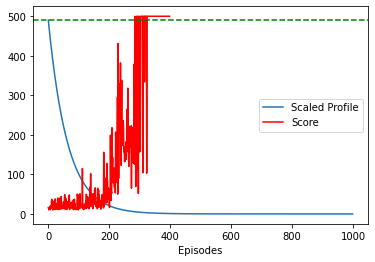

TOP Trial Number 1


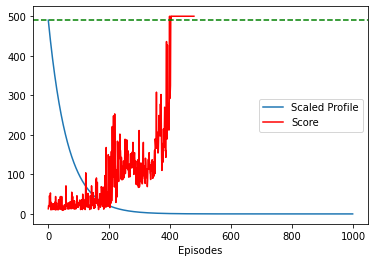

TOP Trial Number 2


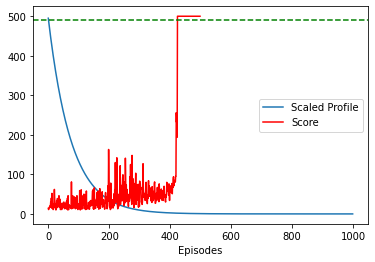

TOP Trial Number 3


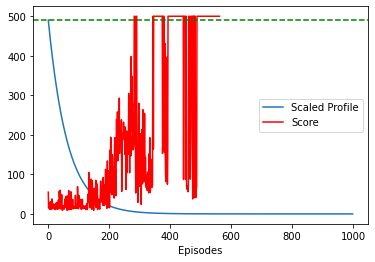

TOP Trial Number 4


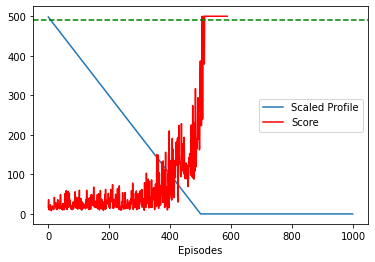

TOP Trial Number 5


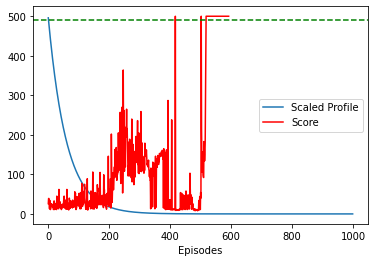

TOP Trial Number 6


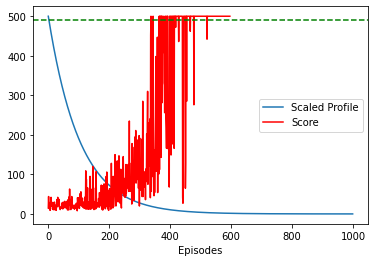

TOP Trial Number 7


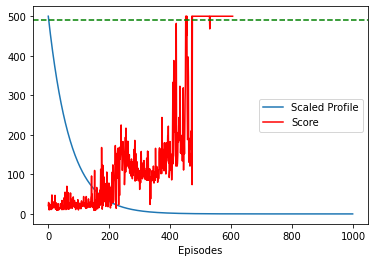

TOP Trial Number 8


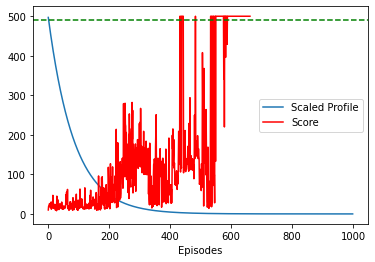

TOP Trial Number 9


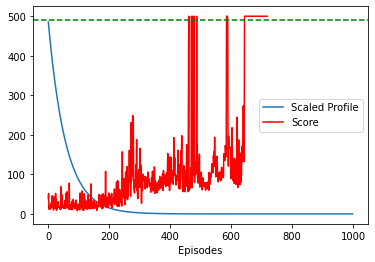

TOP Trial Number 10


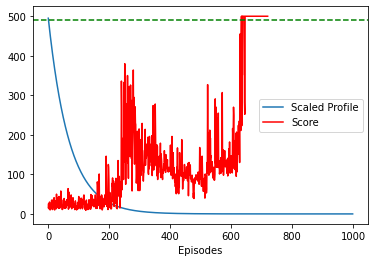

TOP Trial Number 11


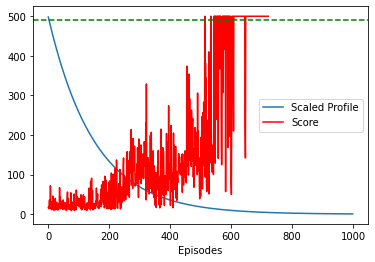

TOP Trial Number 12


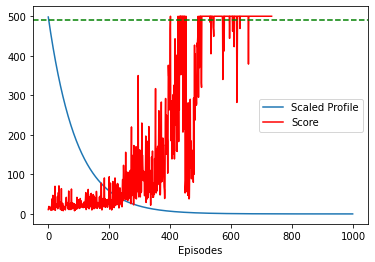

TOP Trial Number 13


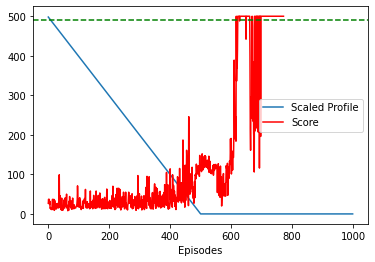

TOP Trial Number 14


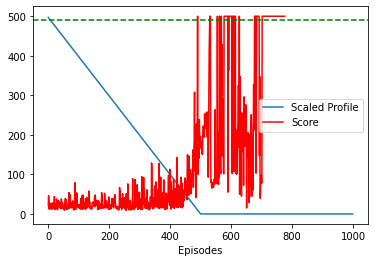

TOP Trial Number 15


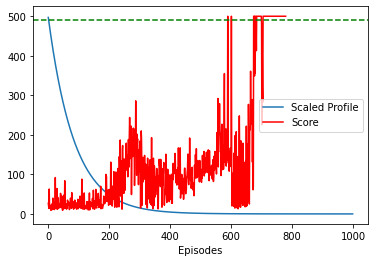

TOP Trial Number 16


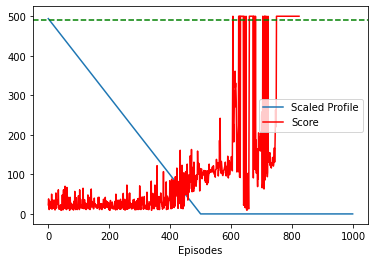

TOP Trial Number 17


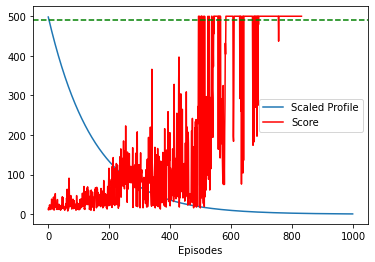

TOP Trial Number 18


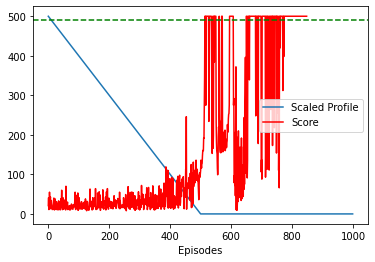

TOP Trial Number 19


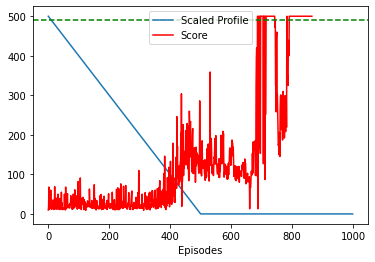

TOP Trial Number 20


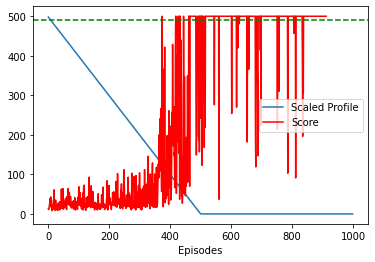

TOP Trial Number 21


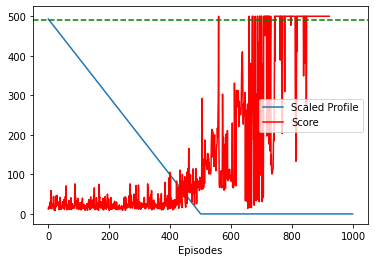

TOP Trial Number 22


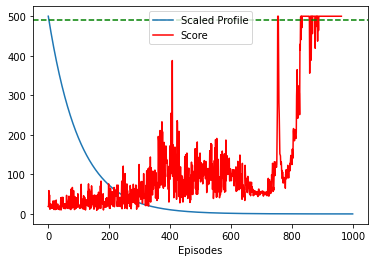

TOP Trial Number 23


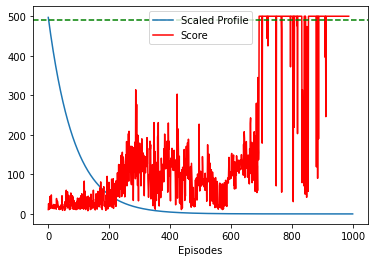

TOP Trial Number 24


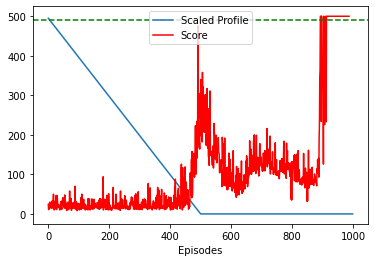

In [ ]:
for rank,i in enumerate(df.index) : 
  p  = track.prof_list[i]
  s = track.scores[i]
  ti = p[0]

  print(f"TOP Trial Number {rank}")
  scale = 500//ti 
  plt.plot(scale*p, label = "Scaled Profile")
  plt.plot(np.array(s), label = 'Score',color="red")
  plt.axhline(490, linestyle='--',color="green")
  plt.xlabel("Episodes")
  plt.ylabel("")
  plt.legend()
  plt.show()

In [ ]:
df.reset_index().loc[0]


index                              46.000000
values_1                          324.000000
params_gamma                        0.954958
params_lr                           0.045000
params_max_temp                    14.000000
params_target_net_update_steps      2.000000
params_type_penalty                 1.000000
params_type_profile                 0.000000
Name: 0, dtype: float64

#test models

In [ ]:
b = df.reset_index().loc[0]
type_penalty = b['params_type_penalty']
type_profile = b['params_type_profile']
temp_max = b['params_max_temp']
gamma = b['params_gamma']
target_net_update_steps = b['params_target_net_update_steps']
lrt= b['params_lr']

x=75  #number of step to consider a model arrived to convergence
### Initialize the replay memory
replay_mem = ReplayMemory(10000)    

### Initialize the policy network
policy_net = DQN(4, 2)

### Initialize the target network with the same weights of the policy network
target_net = DQN(4, 2)
#target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lrt) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()
    
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
    
done_counter=0

pr = Profile(type_profile, temp_max, MAX_ITER)
for i in range(n_noise):
  pr.add_gnoise()
profile = pr._profile()
        
score_list = []
loss_fn = nn.SmoothL1Loss()
    
for episode_num, tau in enumerate(tqdm(profile)):
  
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done  = False

    # Go on until the pole falls off
    while not done:
      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.power(np.abs(state[0]),type_penalty) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
           update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, train_dict.get('batch_size'))
      #env.render()
      # Set the current state for the next iteration
      state = next_state
            
    if score==500:
      done_counter+=1
    else: done_counter=0

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
      target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network       

    if done_counter== x:
      env.close()
      break

    env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done :
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0
EPISODE 11 - FINAL SCORE: 500.0
EPISODE 12 - FINAL SCORE: 500.0
EPISODE 13 - FINAL SCORE: 500.0
EPISODE 14 - FINAL SCORE: 500.0
EPISODE 15 - FINAL SCORE: 500.0
EPISODE 16 - FINAL SCORE: 500.0
EPISODE 17 - FINAL SCORE: 500.0
EPISODE 18 - FINAL SCORE: 500.0
EPISODE 19 - FINAL SCORE: 500.0
EPISODE 20 - FINAL SCORE: 500.0
EPISODE 21 - FINAL SCORE: 500.0
EPISODE 22 - FINAL SCORE: 500.0
EPISODE 23 - FINAL SCORE: 500.0
EPISODE 24 - FINAL SCORE: 500.0
EPISODE 25 - FINAL SCORE: 500.0
EPISODE 26 - FINAL SCORE: 500.0
EPISODE 27 - FINAL SCORE: 500.0
EPISODE 28 - FINAL SCORE: 500.0
EPISODE 29 - FINAL SCORE: 500.0
EPISODE 30 - FINAL SCORE: 500.0
EPISODE 31 - FINAL SCORE: 500.0
EPISODE 32 - FINA

# How noise bump in the activation profile modify the training ? Case for the best trained model : 

In [ ]:
track_noise=Track()
n_noise = 4

done_counter=0

for noise_number in range(n_noise):
    scores = []
    #profile_l = []
    x=75  #number of step to consider a model arrived to convergence
    ### Initialize the replay memory
    replay_mem = ReplayMemory(10000)    

    ### Initialize the policy network
    policy_net = DQN(4, 2)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(4, 2)
    #target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lrt) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
        
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    #env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
        

    pr = Profile(type_profile, temp_max, MAX_ITER)
    for i in range(noise_number):
        pr.add_gnoise()
    profile = pr._profile()
    #profile_l.append(profile)        
    score_list = []
    loss_fn = nn.SmoothL1Loss()
        
    for episode_num, tau in enumerate(tqdm(profile)):
    
        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done  = False

        # Go on until the pole falls off
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.power(np.abs(state[0]),type_penalty) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, train_dict.get('batch_size'))
            #env.render()
            # Set the current state for the next iteration
            state = next_state
        scores.append(score)        
        if score==500:
            done_counter+=1
        else: done_counter=0

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network       

        if done_counter== x:
            track_noise.add(profile,scores)
            env.close()
            break
    track_noise.add(profile,scores)
    env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

TOP Trial Number 0


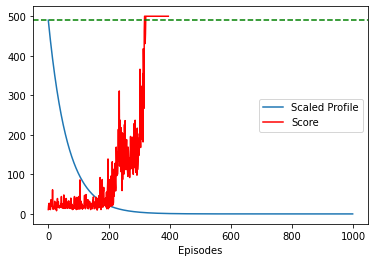

TOP Trial Number 1


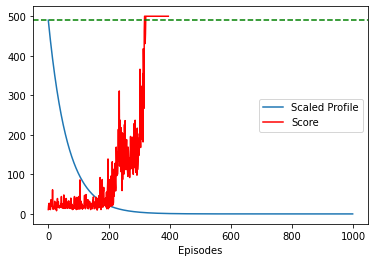

TOP Trial Number 2


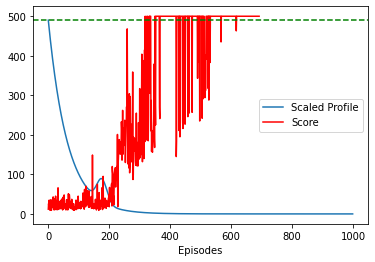

TOP Trial Number 3


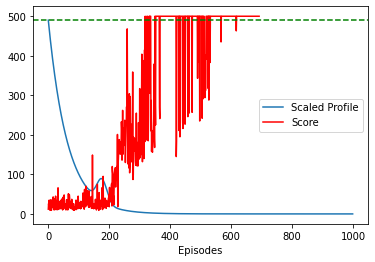

In [ ]:
for rank,i in enumerate(range(n_noise)) : 
  s = track_noise.scores[i]
  p  = track_noise.prof_list[i]
  ti = p[0]

  print(f"TOP Trial Number {rank}")
  scale = 500//ti 
  plt.plot(scale*p, label = "Scaled Profile")
  plt.plot(np.array(s), label = 'Score',color="red")
  plt.axhline(490, linestyle='--',color="green")
  plt.xlabel("Episodes")
  plt.ylabel("")
  plt.legend()
  plt.show()

# Previous run result [Do not run!]
Notice that this run is obtained with a not working linear decaying. Therefore only the dataframe and the convergence plot of the softmax decay is meaningfull.  

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target=lambda t: t.values[1], target_name = "Velocity")

In [ ]:
trials_df = study.trials_dataframe()
trials_df.to_csv('optuna_first.csv')

sort_df=trials_df.sort_values('values_1')[0:25]

filter_col = [col for col in sort_df if col.startswith('param') or col.startswith('values_1')]
df = sort_df[filter_col]
df

,values_1,params_gamma,params_lr,params_max_temp,params_target_net_update_steps,params_type_penalty,params_type_profile
50,279.0,0.953474,0.055,14,1,1.0,0
25,311.0,0.989995,0.027,14,2,1.0,0
41,319.0,0.942929,0.059,18,1,1.5,0
1,342.0,0.989946,0.017,16,1,1.5,0
32,436.0,0.976935,0.047,17,5,1.5,0
37,463.0,0.956563,0.021,6,3,1.0,0
17,571.0,0.942936,0.053,7,2,2.0,0
34,611.0,0.979252,0.051,14,7,1.5,0
28,613.0,0.982373,0.057,4,11,1.5,0
44,641.0,0.979549,0.057,10,6,2.5,0


TOP Trial Number 0


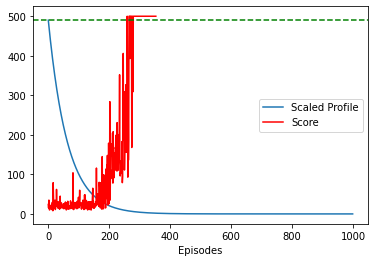

TOP Trial Number 1


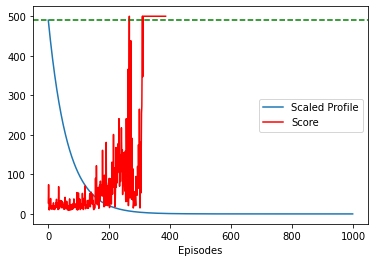

TOP Trial Number 2


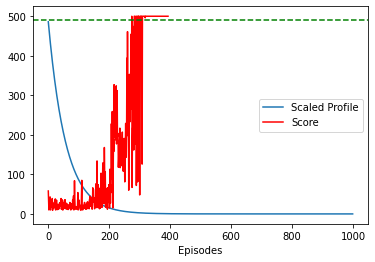

TOP Trial Number 3


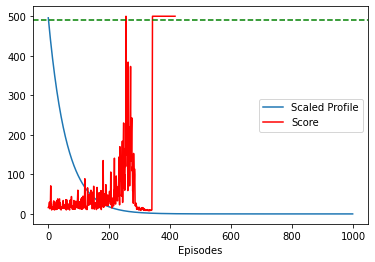

TOP Trial Number 4


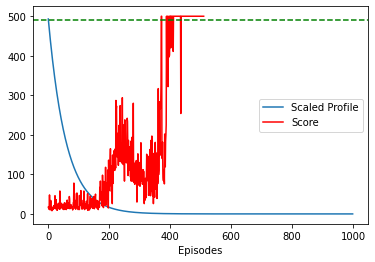

TOP Trial Number 5


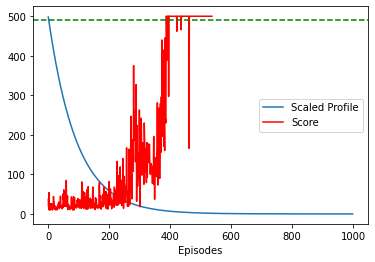

TOP Trial Number 6


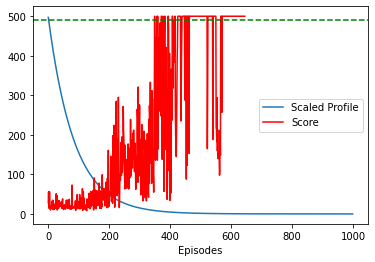

TOP Trial Number 7


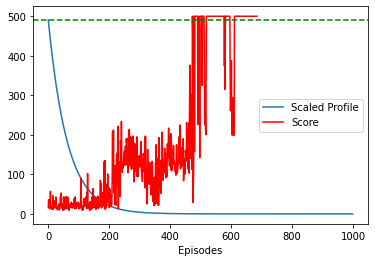

TOP Trial Number 8


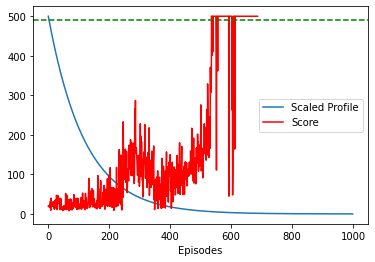

TOP Trial Number 9


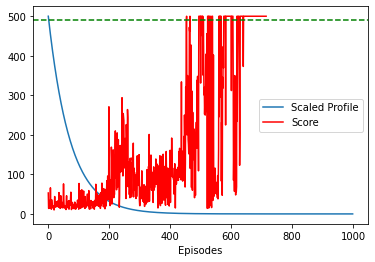

In [ ]:
for rank,i in enumerate(df.index) : 
  p  = track.prof_list[i]
  s = track.scores[i]
  ti = p[0]

  print(f"TOP Trial Number {rank}")
  scale = 500//ti 
  plt.plot(scale*p, label = "Scaled Profile")
  plt.plot(np.array(s), label = 'Score',color="red")
  plt.axhline(490, linestyle='--',color="green")
  plt.xlabel("Episodes")
  plt.ylabel("")
  plt.legend()
  plt.show()

In [ ]:
df.reset_index().loc[0]


index                              50.000000
values_1                          279.000000
params_gamma                        0.953474
params_lr                           0.055000
params_max_temp                    14.000000
params_target_net_update_steps      1.000000
params_type_penalty                 1.000000
params_type_profile                 0.000000
Name: 0, dtype: float64

In [ ]:
b = df.reset_index().loc[0]
type_penalty = b['params_type_penalty']
type_profile = b['params_type_profile']
temp_max = b['params_max_temp']
gamma = b['params_gamma']
target_net_update_steps = b['params_target_net_update_steps']
lrt= b['params_lr']

x=75  #number of step to consider a model arrived to convergence
### Initialize the replay memory
replay_mem = ReplayMemory(10000)    

### Initialize the policy network
policy_net = DQN(4, 2)

### Initialize the target network with the same weights of the policy network
target_net = DQN(4, 2)
#target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lrt) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()
    
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
    
done_counter=0

pr = Profile(type_profile, temp_max, MAX_ITER)
for i in range(n_noise):
  pr.add_gnoise()
profile = pr._profile()
        
score_list = []
loss_fn = nn.SmoothL1Loss()
    
for episode_num, tau in enumerate(tqdm(profile)):
  
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done  = False

    # Go on until the pole falls off
    while not done:
      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.power(np.abs(state[0]),type_penalty) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
           update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, train_dict.get('batch_size'))
      #env.render()
      # Set the current state for the next iteration
      state = next_state
            
    if score==500:
      done_counter+=1
    else: done_counter=0

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
      target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network       

    if done_counter== x:
      env.close()
      break

    env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Exception ignored in: <function Monitor.__del__ at 0x7f9fcd6e84d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 137, in close
    self._close_video_recorder()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 209, in _close_video_recorder
    self.video_recorder.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 129, in close
    os.remove(self.path)
FileNotFoundError: [Errno 2] No such file or directory: '/content/video/openaigym.video.14.70.video000000.mp4'
Exception ignored in: <function Monitor.__del__ at 0x7f9fcd6e84d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/mon

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done :
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0
EPISODE 11 - FINAL SCORE: 500.0
EPISODE 12 - FINAL SCORE: 500.0
EPISODE 13 - FINAL SCORE: 500.0
EPISODE 14 - FINAL SCORE: 500.0
EPISODE 15 - FINAL SCORE: 500.0
EPISODE 16 - FINAL SCORE: 500.0
EPISODE 17 - FINAL SCORE: 500.0
EPISODE 18 - FINAL SCORE: 500.0
EPISODE 19 - FINAL SCORE: 500.0
EPISODE 20 - FINAL SCORE: 500.0
EPISODE 21 - FINAL SCORE: 500.0
EPISODE 22 - FINAL SCORE: 500.0
EPISODE 23 - FINAL SCORE: 500.0
EPISODE 24 - FINAL SCORE: 500.0
EPISODE 25 - FINAL SCORE: 500.0
EPISODE 26 - FINAL SCORE: 500.0
EPISODE 27 - FINAL SCORE: 500.0
EPISODE 28 - FINAL SCORE: 500.0
EPISODE 29 - FINAL SCORE: 500.0
EPISODE 30 - FINAL SCORE: 500.0
EPISODE 31 - FINAL SCORE: 500.0
EPISODE 32 - FINA